## set up and define models
Notations:
* dataset size: $P$
* input feature size: $N$
* parallel synapses per axon: $M$
* hidden layer size (if it's 2-layered neural network): $H$
* output dimension: $O$
* input $x$ has dimension: $[P, N]$

__One layer neural network__ (1-NN):\
Weight matrix $w$ has size $[N, O]$\
Output for each class is $Softmax(x.w)$

__Two layer neural network__ (2-NN):\
Layer 1 weight $w_1$ has size $[H, N]$\
Layer 2 weight $w_2$ has size $[O, H]$\
Hidden layer has output $h = Relu(x.w_1)$\
Output for each class is $Softmax(h.w_2)$

__Parallel synapse neuron__ (1-pNeuron):\
Use $f_M$ to denote element-wise transformation of input, which has $3*M$ learnable parameters for each input dimension\
Input $x$ undergoes parallel synapse computation $f_M(x)$\
Output for each class is $Softmax(f_M(x).w)$

__Two layer neural network with parallel synapse__ (2-NN w pNeuron):\
Again, use $f_M$ to denote element-wise transformation of input,\
Input $x$ undergoes parallel synapse computation $f_M(x)$\
Layer 1 weight $w_1$ has size $[H, N]$, \
Layer 2 weight $w_2$ has size $[O, H]$
Hidden layer has output $h = Relu(f_M(x).w_1)$, \
Output for each class is $Softmax(h.w_2)$


| Model name | #Parameters | #Nonlinear Functions |
|---------|---------|---------|
| 1-NN| $N * O$ | O |
| 2-NN| $H*N + H*O$ | H + O |
| 1-pNeuron|  $3M * N + N * O$  | N + O |
| 2-NN w pNeuron| $3M * N + H * N +  H * O$ | M + H + O |

For fair comparison between 2-NN and 1-pNeuron, I choose $H = 3M$ for 2-NN.\
For fair comparison between 2-NN and 2NN w pNeuron, I choose 2-NN with $4M$ hidden size, and 2-NN w pNeuron with $M$ hidden size.

In [41]:
import math
from typing import Any

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F 
from torch.nn import Module, init
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms

# Check for GPU availability
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

# define one-layered neural network
class oneLayerNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(oneLayerNN, self).__init__()
        self.fc = nn.Linear(input_dim,  output_dim)
        
    def forward(self, x):
        x = self.fc(x)
        return F.log_softmax(x, dim = 0)

# define two-layered neural network
class twoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(twoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim = 0)

# define one neuron with parallel synapses
class ParallelSynapse(Module):
    def __init__(self, input_dim: int, parallel_syns: int, output_dim: int, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.input_dim = input_dim
        self.parallel_syns = parallel_syns
        self.output_dim = output_dim
        
        self.thres = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs))
        self.slope = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs))
        self.ampli = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs)) 
        
        self.fc = nn.Linear(input_dim, output_dim)
        
        self.reset_parameters()
        
    def reset_parameters(self) -> None: 
        init.uniform_(self.thres, a = -1.5, b = 1.5)
        init.kaiming_uniform_(self.ampli, a=math.sqrt(5))
        init.uniform_(self.slope, a = 5, b = 20) 
        
    def forward(self, input: Tensor):
        '''
        input: [data_points, input_dim]
        '''
        data_points = input.shape[0]
        synapse_input = self.slope[None,:,:].expand(data_points, self.parallel_syns, self.input_dim) \
                        * input[:,None, :].expand( data_points, self.parallel_syns, self.input_dim) \
                        - self.thres[None, :,:].expand(data_points,self.parallel_syns, self.input_dim) 
        synapse_output = self.ampli[None,:,:].expand(data_points, self.parallel_syns, self.input_dim)**2  \
                        * torch.sigmoid(synapse_input) 
        
        x = synapse_output.sum(dim = -2).squeeze()
        x = self.fc(x)
        return F.log_softmax(x, dim = 0)

# define two-layered neural network, inputs are processed via parallel synapses
class twoLayerNNwParallelSyn(nn.Module):
    def __init__(self, input_dim: int, parallel_syns: int, hidden_dim: int, output_dim: int, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.parallel_syns = parallel_syns
        self.output_dim = output_dim
        
        self.thres = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs))
        self.slope = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs))
        self.ampli = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs)) 
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.reset_parameters()
        
    def reset_parameters(self) -> None: 
        init.uniform_(self.thres, a = -1.5, b = 1.5)
        init.kaiming_uniform_(self.ampli, a=math.sqrt(5))
        init.uniform_(self.slope, a = 5, b = 20) 

    def forward(self, input: Tensor):
        data_points = input.shape[0]
        synapse_input = self.slope[None, :,:].expand(data_points,  self.parallel_syns, self.input_dim) \
                        * input[:,None,   :].expand( data_points,  self.parallel_syns, self.input_dim) \
                        - self.thres[None,  :,:].expand(data_points,  self.parallel_syns, self.input_dim) 
        synapse_output = self.ampli[None,  :,:].expand(data_points,  self.parallel_syns, self.input_dim)**2  \
                        *  torch.sigmoid(synapse_input)  # data_points, 1, self.parallel_syns, self.input_dim
                        
        x = synapse_output.sum(dim = -2).squeeze() 
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim = 0)


In [42]:
import pandas as pd
def train_models(seed, M = 5,  
                in_dim = 28, out_dim = 10, 
                save = False, path = './data/models/',
                num_epochs = 20,
                verbose = True):
    '''
    INPUTs:
        seed: int, 
            manual seeds for initialization
        M: int, 
            specifying number of parallel synapses
        save: bool = False, 
            whether to save the model
    OUTPUTs:
        loss_dict: dict, 
            key: str, model name, 
            value: list of array, multiple seeds of trained model
        acc_dict: dict, 
            key: str, model name, 
            value: list of array, validation accuracy
    '''
    torch.manual_seed(seed)
    models = {
        '1-NN':  oneLayerNN(in_dim* in_dim, out_dim), \
        '2-NN (H={:d})'.format(3*M):  twoLayerNN(in_dim * in_dim, 3 * M, out_dim), \
        '1-NN with parallel synapse':  ParallelSynapse(in_dim * in_dim, M, out_dim), \
        '2-NN (H={:d})'.format(4*M):  twoLayerNN(in_dim * in_dim, 4 * M, out_dim),\
        '2-NN with parallel synapse (H={:d})'.format(3*M):  twoLayerNNwParallelSyn(in_dim * in_dim, M, M, out_dim)
        }
    accuracies = {}
    losses = {}
    for m in models:
        accuracies[m] = []
        losses[m] = []
            
    # Load the MNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
    
    for model_name in models:
        model = models[model_name]
        # Initialize model, criterion, and optimizer 
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        for epoch in range(num_epochs):
            # Training loop
            if model_name in ['1-NN with parallel synapse', '2-NN with parallel synapse (H={:d})'.format(3*M)]:
                with torch.no_grad():
                    model.thres.data = torch.clamp(model.thres.data, -1.5, 1.5)
                
            model.train()
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(trainloader):
                inputs = inputs.view(-1, 28*28).to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = F.nll_loss(outputs, labels) 
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            losses[model_name].append(running_loss / len(trainloader))
            # Validation loop for accuracy
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs = inputs.view(-1, 28*28).to(device)
                    labels = labels.to(device)
                    
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

            accuracy = 100 * correct / total 
            accuracies[model_name].append(accuracy)
            if verbose and epoch % 10 == 0:
                print(model_name + f" Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")
    
    return {'seed': seed, 
            'M': M,
            'models': models,
            'accuracies': accuracies,
            'losses': losses
            }

In [43]:
def plot_result(result_dict):
    losses = result_dict['losses']
    accuracies = result_dict['accuracies']
    models = result_dict['models']

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for m in models:
        plt.plot(losses[m], label="training loss "+ m)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    for m in models:
        plt.plot(accuracies[m], label="val acc "+ m)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()


1-NN Epoch 1/20, Loss: 1.8728, Accuracy: 88.99%
1-NN Epoch 11/20, Loss: 1.7828, Accuracy: 88.88%
2-NN (H=15) Epoch 1/20, Loss: 1.9113, Accuracy: 88.75%
2-NN (H=15) Epoch 11/20, Loss: 1.6693, Accuracy: 90.47%
1-NN with parallel synapse Epoch 1/20, Loss: 1.9899, Accuracy: 88.93%
1-NN with parallel synapse Epoch 11/20, Loss: 1.7683, Accuracy: 89.49%
2-NN (H=20) Epoch 1/20, Loss: 1.8910, Accuracy: 89.42%
2-NN (H=20) Epoch 11/20, Loss: 1.6213, Accuracy: 91.49%
2-NN with parallel synapse (H=15) Epoch 1/20, Loss: 2.3558, Accuracy: 81.11%
2-NN with parallel synapse (H=15) Epoch 11/20, Loss: 1.9866, Accuracy: 83.04%


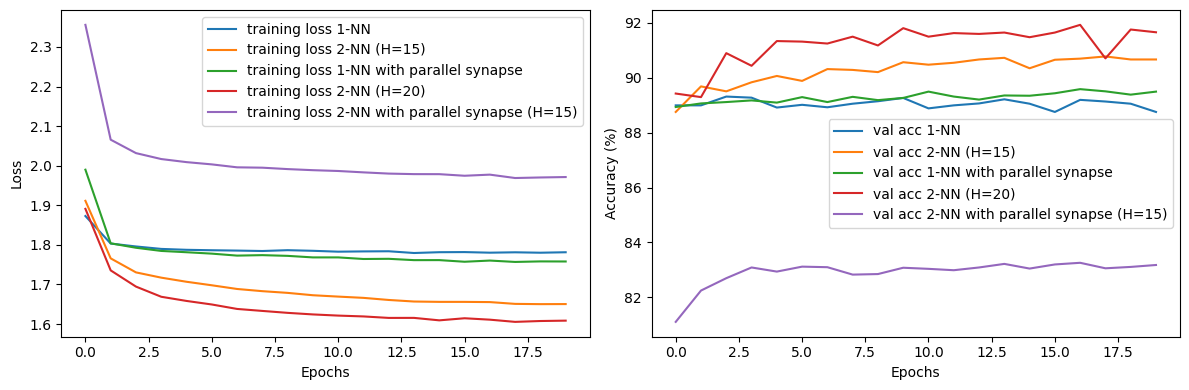

In [44]:
import pickle
experiment = []

for i in range(1):
    result_dict = train_models(i, num_epochs = 20)
    experiment.append(result_dict)
    plot_result(result_dict)

    df = pd.DataFrame(experiment)
    with open('./data/MNIST_result.pkl', 'wb') as f:
        pickle.dump(df, f)

plot aggregate synatic function for parallel synapses 

In [45]:
import pandas as pd
df = pd.read_pickle('./data/MNIST_result.pkl')


In [46]:
df['models'][0].keys()

dict_keys(['1-NN', '2-NN (H=15)', '1-NN with parallel synapse', '2-NN (H=20)', '2-NN with parallel synapse (H=15)'])

In [47]:
df['models'][0]['1-NN with parallel synapse']

ParallelSynapse(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

In [48]:
def plot_aggregate_synaptic_function(ampli, slope, thres):
    input_dim = ampli.shape[1]
    n_input = 100
    input = torch.linspace(-2, 2, n_input)[:, None].expand(n_input, input_dim) # shape: [n_input]
    parallel_syns = ampli.shape[0]
    
    synapse_input = slope[None, :,:].expand(n_input,  parallel_syns, input_dim) \
                        * input[:,None,   :].expand( n_input, parallel_syns, input_dim) \
                        - thres[None,  :,:].expand(n_input, parallel_syns, input_dim) 
                        
    synapse_output = ampli[None,  :,:].expand(n_input, parallel_syns, input_dim)**2  \
                    *  torch.sigmoid(synapse_input)  # data_points, 1, self.parallel_syns, self.input_dim
                    
    synapse_output = synapse_output.sum(dim = -2).squeeze()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.plot(input.detach().numpy(), synapse_output.detach().numpy())
    plt.xlabel('Input')
    plt.ylabel('Aggregate synaptic output')
    plt.subplot(1, 4, 2)
    plt.hist(ampli.detach().numpy().flatten(), bins = 20)
    plt.xlabel('Amplitude')
    plt.ylabel('Count')
    plt.subplot(1, 4, 3)
    plt.hist(slope.detach().numpy().flatten(), bins = 20)
    plt.xlabel('Slope')
    plt.ylabel('Count')
    plt.subplot(1, 4, 4)
    plt.hist(thres.detach().numpy().flatten(), bins = 20)
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.tight_layout()
    

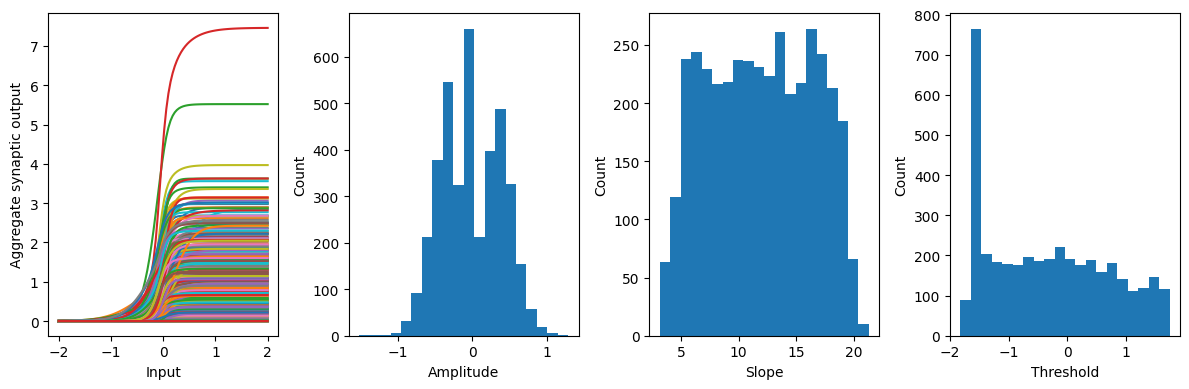

In [49]:
plot_aggregate_synaptic_function(df['models'][0]['1-NN with parallel synapse'].ampli,
                                df['models'][0]['1-NN with parallel synapse'].slope,
                                df['models'][0]['1-NN with parallel synapse'].thres)

In [50]:
df['models'][0]['1-NN with parallel synapse'].ampli.shape

torch.Size([5, 784])

In [51]:
transforms.Normalize

torchvision.transforms.transforms.Normalize